What if we want to use Google Earth Engine for our own region of interest? This could be our own field boundary,  watershed, or perhaps some experimental plot. The nice part, is the we can turn any vector map into a GEE Geometry using a GeoJSON file. Let's dive into an example using a boundary layer for the Ogallala Aquifer.

You can download the file from the [Github repository](https://github.com/soilwater/pynotes-gee/blob/main/datasets/ogallala_aquifer_bnd.geojson)

In [1]:
# Import modules
import ee
import json
import requests
import matplotlib.pyplot as plt
import xarray as xr
import io


In [2]:
# Authenticate
#ee.Authenticate()

# Initialize the library.
ee.Initialize()

#### Load vector file from local drive

In this case we will load the boundary of the Ogallala Aquifer, spanning multiple states in the U.S. Great Plains. The map is in the `GeoJSON` format. You can also use the `GeoPandas` module to read shapefiles, and then convert them into GeJSON siles.

In [3]:
# Import boundary for Ogallala Aquifer

# From local drive
filename_bnd = '../datasets/ogallala_aquifer_bnd.geojson'

# Read the file
with open(filename_bnd) as file:
    roi_json = json.load(file)
    

#### Convert local geojson file into GEEO geometry

In [4]:
# Define the ee.Geometry so that GEE can use it
roi_geom = ee.Geometry(roi_json['features'][0]['geometry'])

# Create mask
mask = ee.Image.constant(1).clip(roi_geom).mask()


#### Learn how to unpack coordinates

For plotting purposes we will need to access the list of geographic coordinates from the `GeoJSON` structure. The coordinates are stored in `[lon, lat]` pairs. Here is an example: 

```
[[-105.08669315719459, 41.81747353490203],
 [-105.12647954793552, 41.819996817840824],
 [-105.14733301403585, 41.821369666176125]]
```

The catch is that for plotting we need latitude and longitude in separate lists. Here is where Python shines. We typically use the `zip` function to create the above structure from individual columns. We can use the same `zip` function with the `*` operator to do the inverse. Sometimes we call this operation `unpacking`, because we turn a list packed with other lists, into separate lists.

First we need to learn how to access the raw data that we need. The code line belows shows how to access the nested coordinates, so that then we can use this line with the `zip` function. Remember to go step by step when breaking down the problem.


In [ ]:
# Visualize the coordinates inside of the geojson file (output is long!)
print(roi_json['features'][0]['geometry']['coordinates'][0])


In [6]:
# Apply the zip function (note the use of *
# Recall that lon is first and lat second in the geojson file
# this is because coordinates are stored as x,y pairs (lon is x, and lat is y)

lon,lat = zip(*roi_json['features'][0]['geometry']['coordinates'][0])


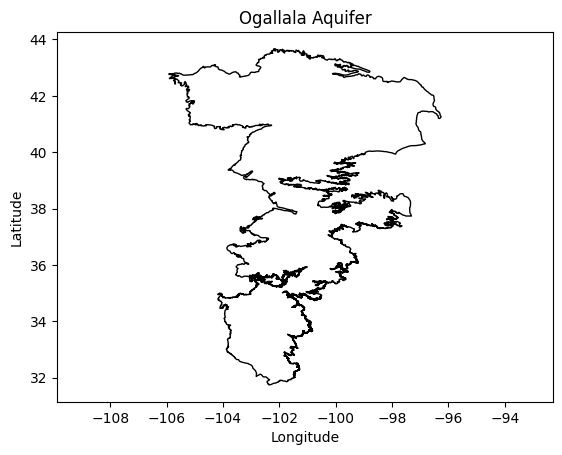

In [7]:
# Display vector map to ensure everything looks good.
plt.figure()
plt.plot(lon, lat, color='k', linewidth=1)
plt.title('Ogallala Aquifer')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()


#### Load GEE datasets

For this tutorial we will load the mean saturated hydraulic conductivity layer from the USDA-NRCS Soil Survey GeoDatabase (SSURGO, see Walkinshaw et al. 2020). Since the saturated hydraulic conductivity represents the permeablity of the soil under saturated conditions, this layer will reveal places where the potential for aquifer recharge is greatest. Note the word "potential", since soils in this region are rarely saturated due to the low annual precipitation regime.


In [8]:
# Load GEE layers
ksat = ee.Image('projects/earthengine-legacy/assets/projects/sat-io/open-datasets/CSRL_soil_properties/physical/ksat_mean')

# Clip image to region of interest
factor = 1/(10e4) * 86400 # To convert micrometers/second to cm/day
ksat = ksat.select('b1').multiply(factor).clip(roi_geom).mask(mask)


In [9]:
# Note that this cell will take a few seconds, the area we are requesting 
# is large and has a complex shape

# Get map from url 
image_url = ksat.getDownloadUrl({
    'region': roi_geom,
    'scale':800,
    'crs': 'EPSG:4326',
    'format': 'GEO_TIFF'})

# Request data using URL and save data as a new GeoTiff file
response = requests.get(image_url)
    

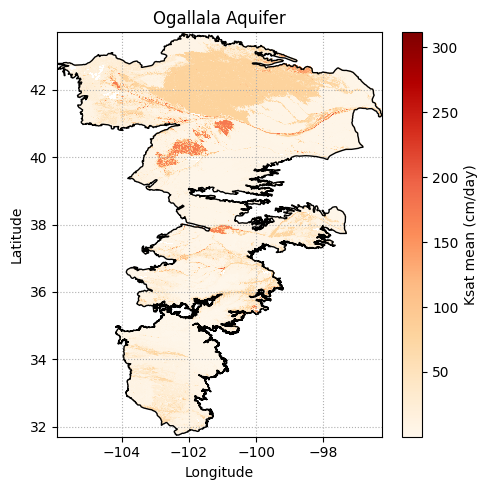

In [10]:
# Check if the request was successful
if response.status_code == 200:
    
    # Read image data into a BytesIO object
    image_data = io.BytesIO(response.content)
    
    # Use Xarray to open the raster image directly from memory
    raster = xr.open_dataarray(image_data, engine='rasterio').squeeze()
    
    raster.plot.imshow(figsize=(5,5) , cmap='OrRd', add_colorbar=True,
                       cbar_kwargs={'label':'Ksat mean (cm/day)'})
    plt.plot(lon, lat, color='k', linewidth=1)
    
    plt.title('Ogallala Aquifer')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.axis('equal')
    plt.tight_layout()
    plt.grid(linestyle=':')
    plt.show()
    


#### Add state boundaries to map

This part requires using the GeoPandas library to clip and overlay the map of U.S. states on the aquifer map.

In [11]:
import geopandas as gpd

In [12]:
# Read US states
US_states = ee.FeatureCollection("TIGER/2018/States").filterBounds(roi_geom)

# Simplifgeometry boundary to download less data
US_states_simple = US_states.map(lambda feature: feature.simplify(maxError=100)).getInfo()


In [13]:
# Convert region of interest from json to GeoDataframe
roi_gdf = gpd.GeoDataFrame.from_features(roi_json)

# Use GeoPandas to convert US_states into GeoDataframe
US_states_clipped = gpd.GeoDataFrame.from_features(US_states_simple).clip(roi_gdf.total_bounds)


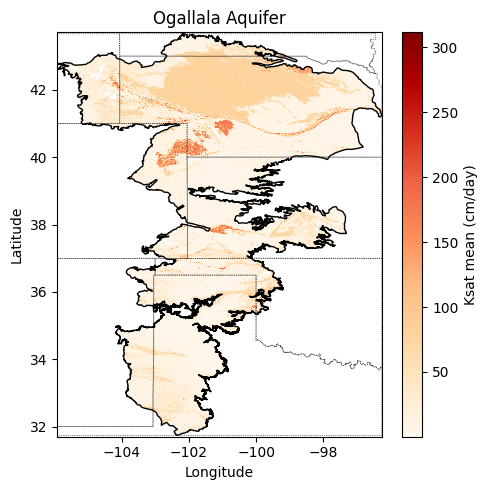

In [14]:
# Check if the request was successful
if response.status_code == 200:
    
    # Read image data into a BytesIO object
    image_data = io.BytesIO(response.content)
    
    # Use Xarray to open the raster image directly from memory
    raster = xr.open_dataarray(image_data, engine='rasterio').squeeze()
    
    plt.figure(figsize=(5,5))
    raster.plot.imshow(cmap='OrRd', add_colorbar=True,
                       cbar_kwargs={'label':'Ksat mean (cm/day)'})
    plt.plot(lon, lat, color='k', linewidth=1)

    # Mute this line to avoid 
    US_states_clipped.plot(ax=plt.gca(),
                           facecolor='None', 
                           edgecolor='k',
                          linewidth=0.5, linestyle=':')

    plt.title('Ogallala Aquifer')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    

## References

- Walkinshaw, M., O'Geen, A., & Beaudette, D. (2021). Soil properties. California Soil Resource Lab.